# Object Detection

자율 주행에 사용되는 kitti dataset을 RetinaNet에 적용해보자.

## 1. 데이터 준비

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

#### kitti dataset : 자율 주행을 위한 dataset

In [2]:
# 다운로드에 매우 긴 시간이 소요됩니다. 
import urllib3
urllib3.disable_warnings()

data_dir = os.path.join(os.getenv("HOME"), "aiffel/object_detection/data")

(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=data_dir,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

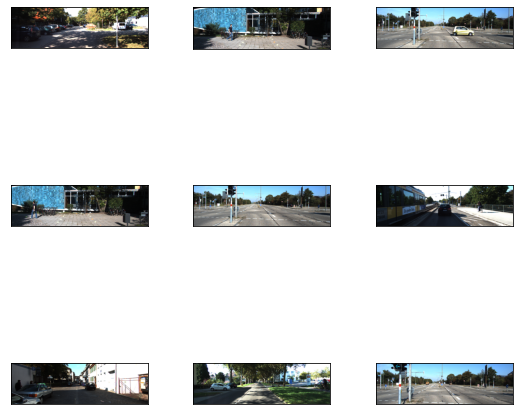

In [3]:
_ = tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

#### 이미지와 objects

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 1.86, -1.58, -1.64], dtype=float32)>, 'bbox': <tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0.20898667, 0.20362319, 0.5363467 , 0.3614815 ],
       [0.40906668, 0.53471017, 0.52088   , 0.56575686],
       [0.4476    , 0.5137037 , 0.50096   , 0.5338406 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1.5 , 1.62, 4.19],
       [1.63, 1.48, 2.37],
       [1.41, 1.58, 4.36]], dtype=float32)>, 'location': <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[-3.73,  1.55, 11.04],
       [ 2.93,  1.91, 29.37],
       [ 3.03,  2.53, 55.02]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([0, 0, 1])>, 'rotation_y': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 1.54, -1.49, -1.59], dtype=float32)>, 'truncated': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0

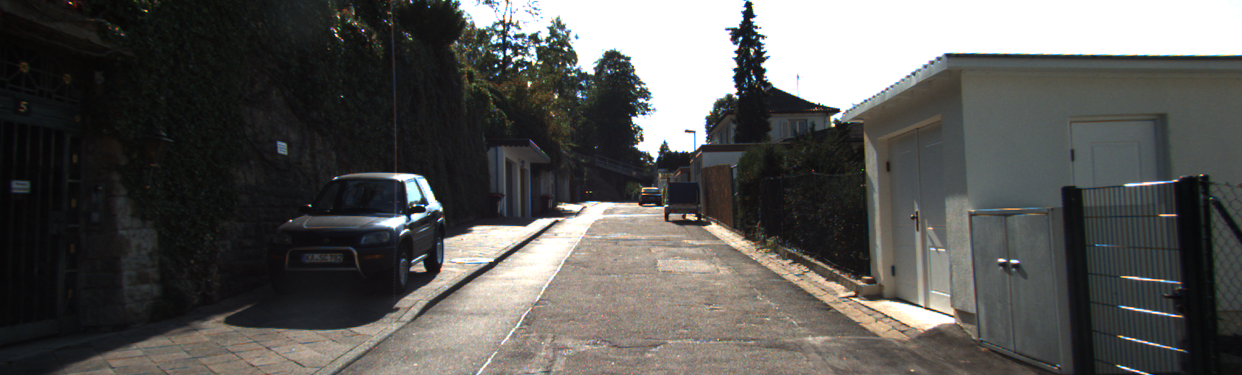

In [11]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

#### bbox 형태에 맞도록 np.stack 후 확인

width: 1242  height: 375
(3, 4)
[252.90001 296.63    448.96002 173.87   ]
[664.11005 221.59999 702.67004 179.67001]
[638.02 207.15 663.03 187.14]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F31001CD0D0>


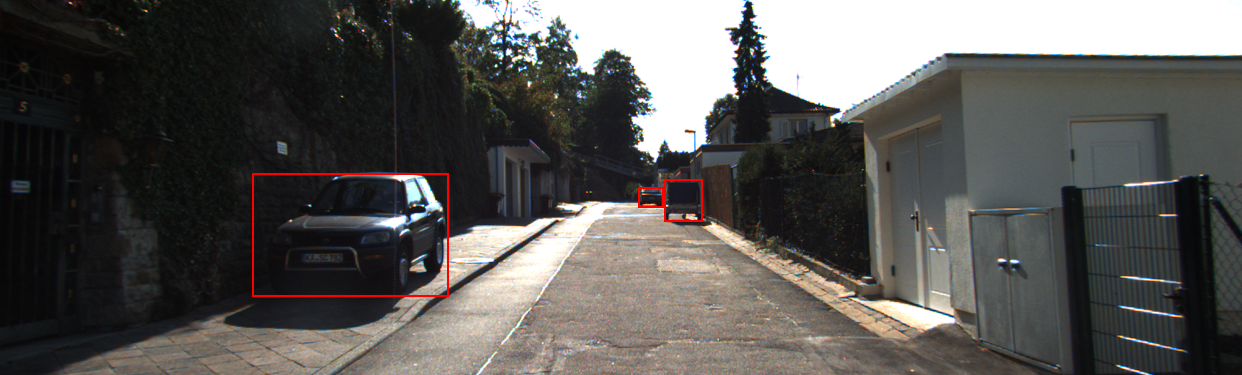

In [16]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

___

## 2. RetinaNet

![image](https://user-images.githubusercontent.com/86637320/136965279-e03156c5-a824-4d1a-9984-22961f14ad25.png)

YOLO, SSD와 같은 **one-stage Network**은 **two-stage Network**에 비해 속도는 빠르지만 성능은 낮다. 이는 object와 background의 극단적인 불균형 때문에 발생한다. 이를 해결하기 위해서 object 클래스에 높은 가중치를 주는 **Focal Loss**를 학습에 활용한다. 이를 통해 **빠른 속도**와 높은 **성능**을 가지는 Detection 모델을 얻을 수 있다. 또한 **FPN**(Feature Pyramid Network)구조를 통해 이미 계산된 특징을 재사용할 수 있게돼 **Scale 변화에 강건**하게 된다.

#### Keras-RetinaNet 
https://github.com/fizyr/keras-retinanet 

- csv 형태로 데이터를 제공해줘야 한다.

#### dataset_to_csv parsing

In [17]:
import os
data_dir = os.getenv('HOME') + '/aiffel/object_detection/data'
img_dir = data_dir + '/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir, total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)
        
        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size
        
        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height
        
        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            
    return df
        
df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',', index=False, header=False)

100%|██████████| 6347/6347 [22:15<00:00,  4.75it/s]


In [18]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',', index=False, header=False)

100%|██████████| 711/711 [02:35<00:00,  4.58it/s]


#### class mapping

In [19]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")
    print('Done')
            
save_class_format(class_txt_path)

Done


## 3. 모델 훈련 및 결과 확인

#### keras_retinanet 패키지 이용해 훈련

In [23]:
# RetinaNet 훈련이 시작됩니다!! 10epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 10 --steps 195 csv data/kitti_train.csv data/classes.txt
print("Done")

2021-10-12 14:13:41.671245: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-12 14:13:43.371584: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-12 14:13:43.372604: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-12 14:13:43.380790: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-10-12 14:13:43.380827: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-12 14:13:43.384234: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-12

In [24]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_10.h5 snapshots/resnet50_csv_10_infer.h5
print("Done")

2021-10-12 15:18:58.316043: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-12 15:19:00.874478: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-12 15:19:00.875425: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-12 15:19:00.883138: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-10-12 15:19:00.883177: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-12 15:19:00.891940: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-12

#### 모델 추론 / 시각화

In [25]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_10_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


#### 추론 결과 확인

- boxes : bbox 좌표 
- scores : IoU 
- labels : 0 = 사물, 1 = 사람, -1 = 배경

[594.07    174.33253 625.9294  205.22244]
[194.45819 130.7248  356.4767  234.83035]
[376.95905 182.9414  415.71902 209.86325]
[534.29895 162.23572 562.3641  190.26428]


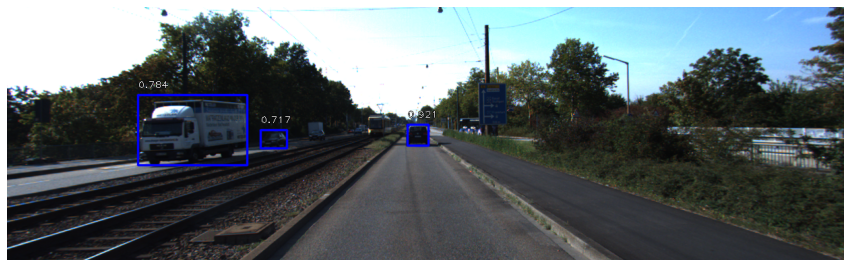

In [38]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path, visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    
    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)
            
            
            

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path)


[771.59155 154.3736  841.56177 297.68787]
[770.0546  154.76604 849.64514 286.67706]


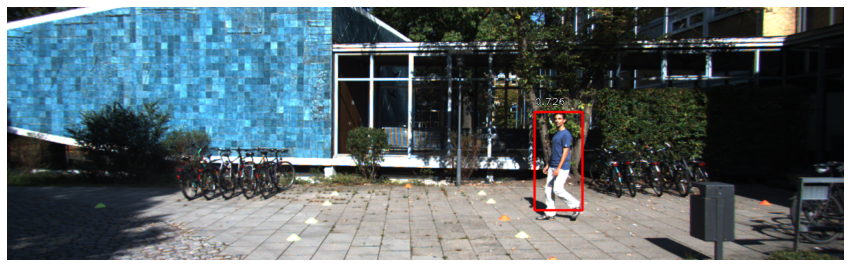

In [27]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path)

___

## 4. 주행 보조 기능 구현

[771.59155 154.3736  841.56177 297.68787]
[770.0546  154.76604 849.64514 286.67706]


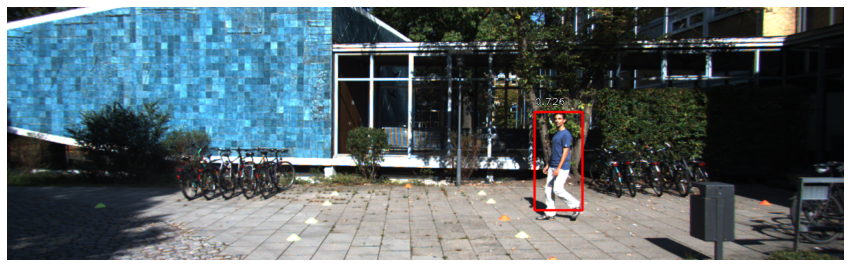

❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗ Stop ❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗


In [51]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'

def self_drive_assist(img_path, size_limit=300, visualize=True):
    # 코드 구현
		# 정지조건에 맞으면 return "Stop"
		# 아닌 경우 return "Go"
        
    signal = "Go"
    
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    
    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            w = b[2]-b[0] #bbox width
            h = b[3]-b[1] #bbox height
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)
            
            if label == 1 or w >= size_limit or h >= size_limit:
                signal = 'Stop'
            
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show() 
    
    print("❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗",signal,"❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗")
    
    return signal

sign = self_drive_assist(img_path)

[771.59155 154.3736  841.56177 297.68787]
[770.0546  154.76604 849.64514 286.67706]


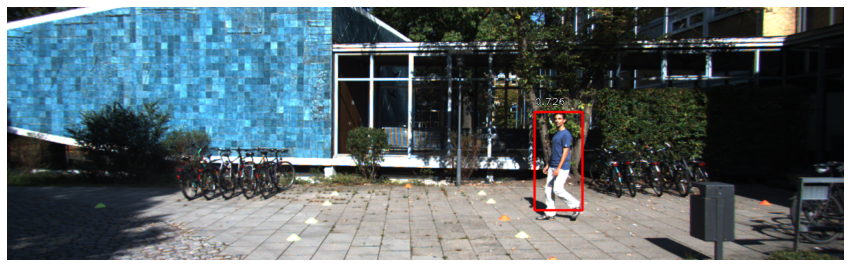

❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗ Stop ❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗
[422.12006 166.6369  497.82297 316.8853 ]
[413.70065 168.51273 502.58932 327.42313]


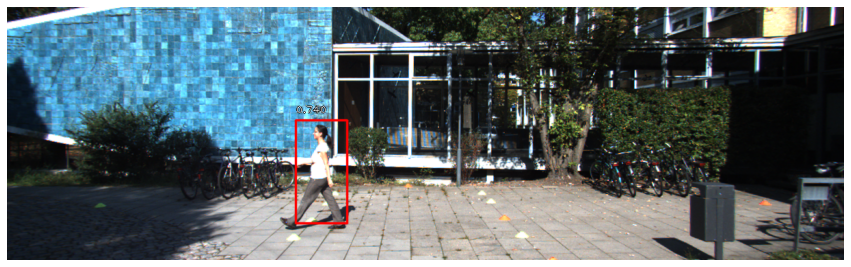

❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗ Stop ❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗
[  0.      206.2284  291.5123  369.12827]
[752.3209  164.11063 873.51733 207.78401]
[ 995.6108   148.82576 1034.974    215.47316]


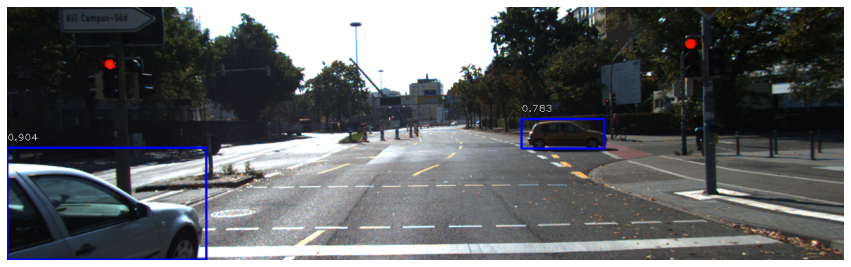

❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗ Go ❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗
[659.30634 144.9027  731.8186  219.20384]
[ 721.2962     62.550438 1087.0012    360.55386 ]
[446.27835 165.28645 549.1892  205.64423]
[ 74.2888  158.58257 372.75153 306.32648]
[672.39435 153.76741 754.6841  235.5018 ]
[360.37024 177.06712 460.3762  215.0113 ]
[651.1017  153.90218 711.23236 208.33394]


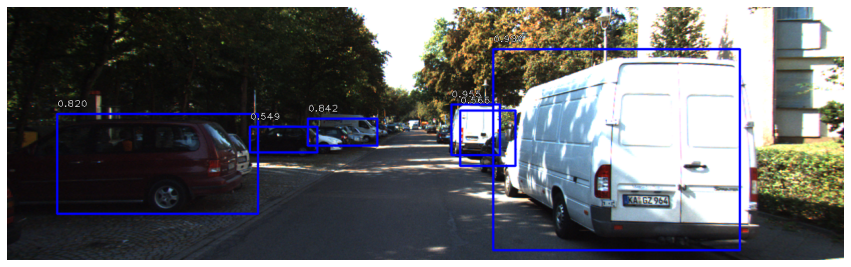

❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗ Stop ❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗
[ 881.7487  172.6752 1241.0684  373.6249]
[729.6189  162.24535 852.40717 249.28764]
[569.20056 181.27463 612.67456 214.34398]
[700.8746  147.72728 777.0015  213.00616]
[712.64105 150.71251 823.8254  230.08817]
[693.2565  153.55867 754.3349  202.52196]


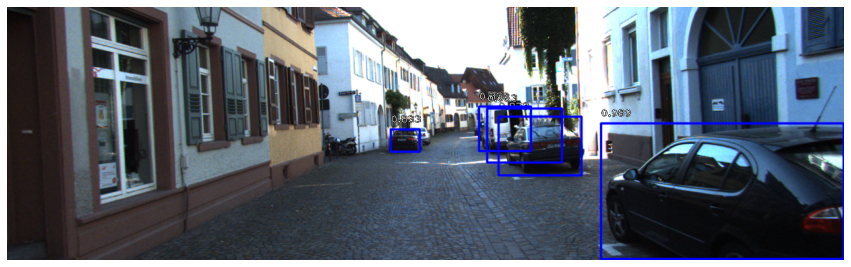

❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗ Stop ❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗
[594.07    174.33253 625.9294  205.22244]
[194.45819 130.7248  356.4767  234.83035]
[376.95905 182.9414  415.71902 209.86325]
[534.29895 162.23572 562.3641  190.26428]


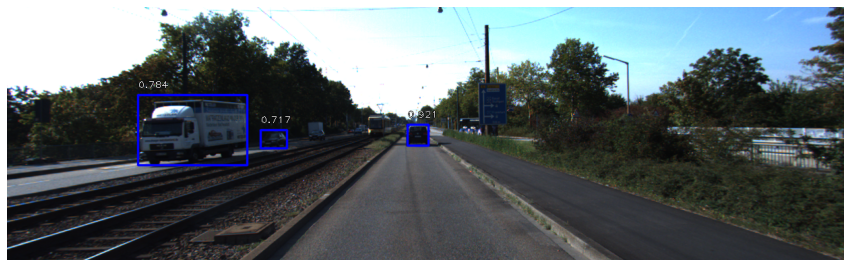

❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗ Go ❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗
[518.63776 179.22704 565.322   215.63467]
[628.29694 175.25275 665.4142  212.04439]
[527.79364 175.43155 578.23834 208.51654]


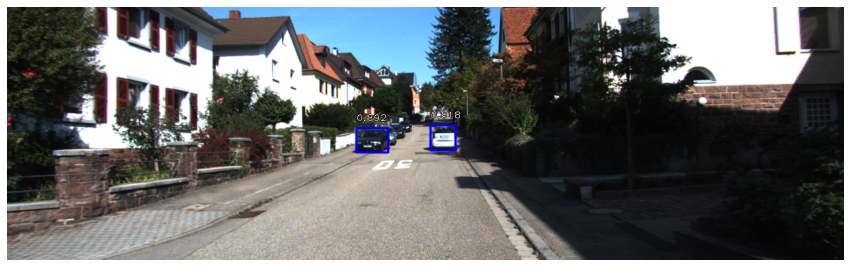

❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗ Go ❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗
[818.84845 149.6505  884.7613  178.40901]
[541.0335  167.5698  568.6891  190.39902]
[407.70645 174.80093 440.4541  196.95801]


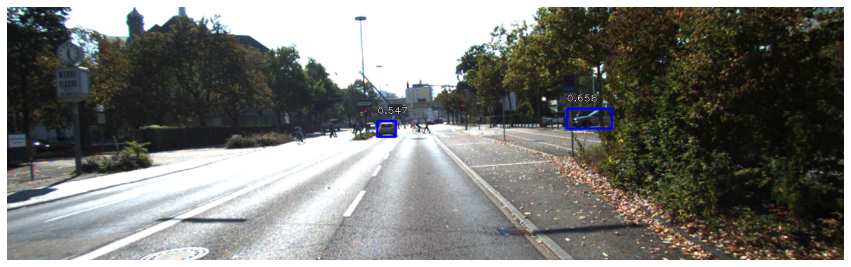

❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗ Go ❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗
[690.5078  171.38193 788.1231  252.21367]
[687.6431  180.69089 753.35846 233.4437 ]


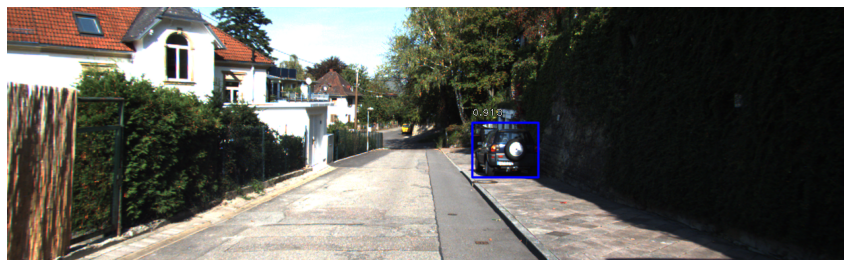

❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗ Go ❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗
[  0.66308564 186.89713    210.4002     303.50854   ]
[155.93147 178.25351 336.12964 256.33594]
[ 76.55463 182.42673 304.5332  269.05624]
[441.44516 179.83562 489.68555 209.4829 ]
[213.84734 180.09267 359.23218 243.37335]


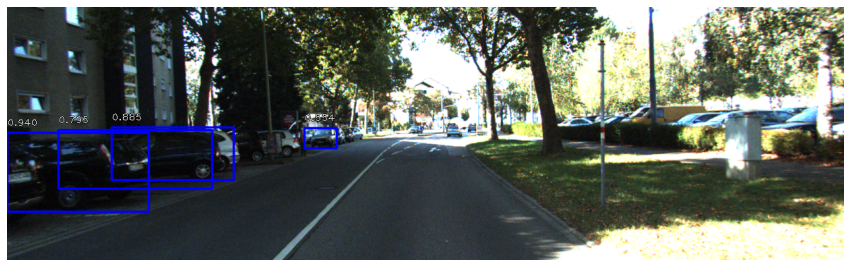

❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗ Go ❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗
90점입니다.


In [52]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

___

# 정리

**Retina-Net**을 통해 Object Detection을 진행했다. 이번엔 모델을 직접 구현하지 않고 github에 구현돼 있는 패키지를 사용했다. 패키지의 요구 조건을 잘 따르면 간단히 모델을 사용할 수 있다는 점이 좋았다. github **README**가 불친절해 사용법을 따로 알아봐야 하는 패키지도 많은데 이번 패키지의 경우 굉장히 설명이 잘 돼있어서 좋았다. **Retina-Net**을 통해 구현한 Object detection은 **90%**의 정확도를 기록했다.